# Split the data

In [1]:
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import sys
sys.path.append("../src")
from reachability_model_holds_features_function import ReachabilityFeaturesGNN
from torch_geometric.data import Batch
from reachability_model_holds_features_function import plot_graph_prediction
from reachability_model_holds_features_function import FocalLoss

In [4]:
# Load the Graphs with edge_attr
data = torch.load("../data/graph_list_holds_features_edgesF.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_2404\45347308.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features_edgesF.pt"

In [2]:
# Load the Graphs
data = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_16764\1844560907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features.pt")


In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Calculate the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([0.0766, 3.2582, 3.3765, 5.0000], device='cuda:0')

# Option 2: Use Balanced to calcualte the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=None, a_max=5.0)
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([0.2699, 5.0000, 5.0000, 5.0000], device='cuda:0')

# Option 3: Manual boost for rare class

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data]).cpu().numpy()

classes = np.unique(all_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_labels)
weights = np.clip(weights, a_min=None, a_max=5.0)

# Boost the type 3
boost_factor = 2.5
weights[3] *= boost_factor

weights = torch.tensor(weights, dtype=torch.float).to(device)

In [7]:
weights

tensor([ 0.2699,  5.0000,  5.0000, 12.5000], device='cuda:0')

# Train the Model

In [8]:
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityFeaturesGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# CrossEntropyLoss
# loss_fn = CrossEntropyLoss(weight=weights)

# FocalLoss
loss_fn = FocalLoss(gamma=1.0, weight=weights)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 1123.0223
Epoch 2: Loss = 757.8692
Epoch 3: Loss = 680.1827
Epoch 4: Loss = 599.3016
Epoch 5: Loss = 407.1131
Epoch 6: Loss = 322.6871
Epoch 7: Loss = 222.8430
Epoch 8: Loss = 170.8450
Epoch 9: Loss = 153.9098
Epoch 10: Loss = 136.9902
Epoch 11: Loss = 126.4599
Epoch 12: Loss = 109.2065
Epoch 13: Loss = 103.5671
Epoch 14: Loss = 82.5137
Epoch 15: Loss = 65.5395
Epoch 16: Loss = 63.3952
Epoch 17: Loss = 70.1867
Epoch 18: Loss = 59.1888
Epoch 19: Loss = 76.9132
Epoch 20: Loss = 78.7548
Epoch 21: Loss = 72.3176
Epoch 22: Loss = 60.2129
Epoch 23: Loss = 55.7361
Epoch 24: Loss = 63.7969
Epoch 25: Loss = 62.7459
Epoch 26: Loss = 54.1146
Epoch 27: Loss = 40.8079
Epoch 28: Loss = 63.7518
Epoch 29: Loss = 50.2441
Epoch 30: Loss = 42.0262
Epoch 31: Loss = 67.9586
Epoch 32: Loss = 45.1479
Epoch 33: Loss = 46.1439
Epoch 34: Loss = 46.8361
Epoch 35: Loss = 47.5883
Epoch 36: Loss = 36.2948
Epoch 37: Loss = 43.6386
Epoch 38: Loss = 39.0083
Epoch 39: Loss = 44.5301
Epoch 40: Loss = 38.

In [9]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device) 
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 1211258, 1: 58129, 2: 52474, 3: 2218})


In [10]:
torch.save(model.state_dict(),"reachability_features_model8.pt")

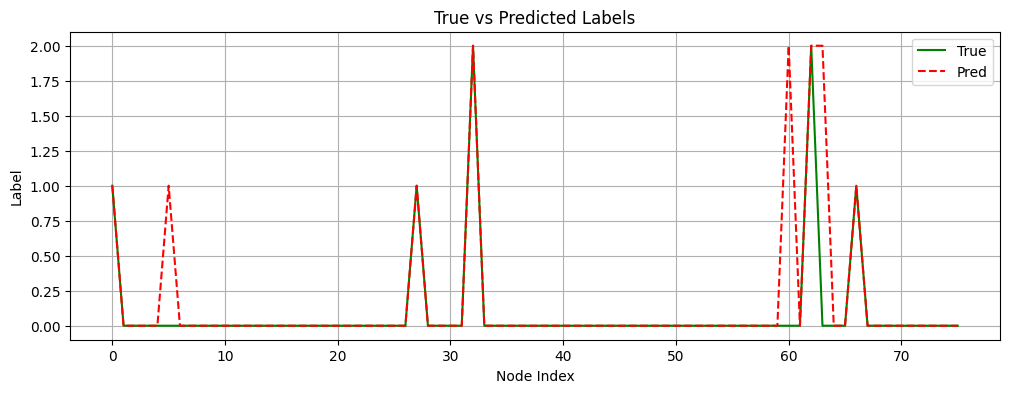

In [11]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[1200]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      0.99      0.99    302683
        hand       0.87      0.99      0.93     12683
        foot       0.86      1.00      0.93     11289
        both       0.66      1.00      0.80       363

    accuracy                           0.99    327018
   macro avg       0.85      1.00      0.91    327018
weighted avg       0.99      0.99      0.99    327018



# Load already had model to check the performance

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReachabilityFeaturesGNN().to(device)
model.load_state_dict(torch.load("reachability_features_model.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_34120\4062656412.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_features_mode

ReachabilityFeaturesGNN(
  (conv1): GCNConv(6, 64)
  (norm1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (norm2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (climber_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [3]:
graph_list = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_34120\2271411771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("../data/graph_list_holds_features.p

In [4]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

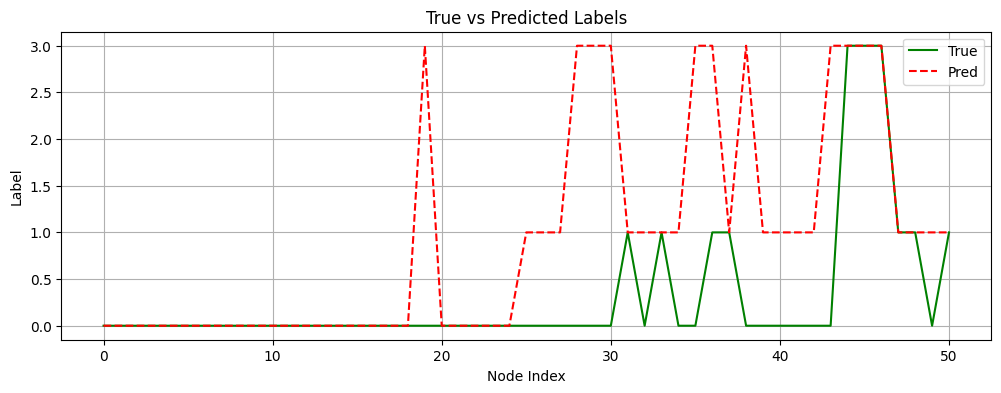

In [17]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 unreachable       0.93      0.46      0.61   1376661
        hand       0.21      0.60      0.31    221572
        foot       0.00      0.00      0.00      2442
        both       0.18      0.52      0.27    155498

    accuracy                           0.48   1756173
   macro avg       0.33      0.39      0.30   1756173
weighted avg       0.77      0.48      0.54   1756173



c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


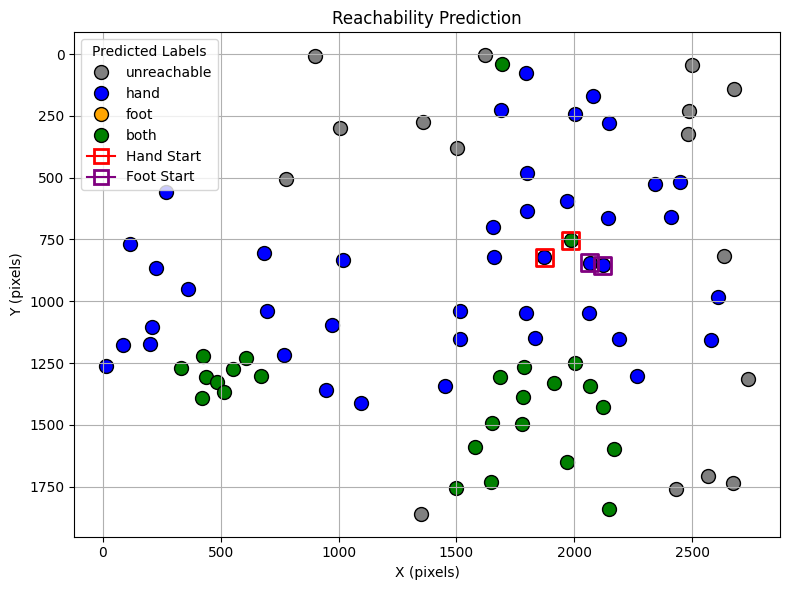

In [6]:
graph = test_data[0]
batch = Batch.from_data_list([graph])
plot_graph_prediction(batch, model, "Reachability Prediction")